In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import time

In [48]:
lena = cv2.imread("lena.jpg", cv2.IMREAD_GRAYSCALE)
lena = lena.astype(np.float32)

In [49]:
h, w = lena.shape

In [50]:
scale = 2
big = cv2.resize(lena, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_LINEAR)

In [51]:
def nn_interpolation(img, new_h, new_w):
    h, w = img.shape
    result = np.zeros((new_h, new_w))

    scale_x = (h-1) / (new_h -1)
    scale_y = (w-1) / (new_w-1)

    for i in range(new_h):
        for j in range(new_w):
            x = int(round(i * scale_x))
            y = int(round(j * scale_y))
            result[i, j] = img[x, y]

    return result


In [52]:
def bilinear_interpolation(img, new_h, new_w):
    h, w = img.shape
    result = np.zeros((new_h, new_w))

    scale_x = (h-1) / (new_h - 1)
    scale_y = (w-1) / (new_w - 1)

    for i in range(new_h):
        for j in range(new_w):
            x = i * scale_x
            y = j * scale_y

            x1, y1 = int(x), int(y)
            x2, y2 = min(x1+1, h-1), min(y1+1, w-1)

            a = x - x1
            b = y - y1

            result[i, j] = (
                (1-a)*(1-b)*img[x1,y1] +
                a*(1-b)*img[x2,y1] +
                (1-a)*b*img[x1,y2] +
                a*b*img[x2,y2]
            )
    return result


In [53]:
def cubic(x, a=-0.5):
    x = abs(x)
    if x <= 1:
        return (a + 2)*x**3 - (a + 3)*x**2 + 1
    elif x < 2:
        return a*x**3 - 5*a*x**2 + 8*a*x - 4*a
    else:
        return 0
    
def reflect(idx, max_idx):
    if idx < 0:
        return -idx
    elif idx >= max_idx:
        return 2*max_idx - idx - 2
    return idx


def bicubic_interpolation(img, new_h, new_w):
    h, w = img.shape
    result = np.zeros((new_h, new_w), dtype=np.float32)

    scale_x = h / new_h
    scale_y = w / new_w

    for i in range(new_h):
        for j in range(new_w):

            x = (i + 0.5) * scale_x - 0.5
            y = (j + 0.5) * scale_y - 0.5

            x_int = int(np.floor(x))
            y_int = int(np.floor(y))

            pixel_sum = 0.0
            weight_sum = 0.0

            for m in range(-1, 3):
                for n in range(-1, 3):
                    xm = reflect(x_int + m, h)
                    yn = reflect(y_int + n, w)

                    wx = cubic(x - (x_int + m))
                    wy = cubic(y - (y_int + n))
                    wxy = wx * wy

                    pixel_sum += img[xm, yn] * wxy
                    weight_sum += wxy

            if weight_sum != 0:
                result[i, j] = pixel_sum / weight_sum
            else:
                result[i, j] = 0

    return np.clip(result, 0, 255)


In [54]:
nn_cv2 = cv2.resize(big, (w, h), interpolation=cv2.INTER_NEAREST)
bilinear_cv2 = cv2.resize(big, (w, h), interpolation=cv2.INTER_LINEAR)
bicubic_cv2 = cv2.resize(big, (w, h), interpolation=cv2.INTER_CUBIC)



In [55]:
def mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)


In [56]:
def psnr(original, reconstructed):
    m = mse(original, reconstructed)
    if m == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(m))


In [57]:
nn_s = nn_interpolation(big, h, w)
bl_s = bilinear_interpolation(big, h, w)
bc_s = bicubic_interpolation(big, h, w)

results = {
    "NN Scratch": (mse(lena, nn_s), psnr(lena, nn_s)),
    "Bilinear Scratch": (mse(lena, bl_s), psnr(lena, bl_s)),
    "Bicubic Scratch": (mse(lena, bc_s), psnr(lena, bc_s)),
    "NN cv2": (mse(lena, nn_cv2), psnr(lena, nn_cv2)),
    "Bilinear cv2": (mse(lena, bilinear_cv2), psnr(lena, bilinear_cv2)),
    "Bicubic cv2": (mse(lena, bicubic_cv2), psnr(lena, bicubic_cv2)),
}

for k, v in results.items():
    print(f"{k:20s}  MSE={v[0]:.2f}, PSNR={v[1]:.2f} dB")


NN Scratch            MSE=10.32, PSNR=38.00 dB
Bilinear Scratch      MSE=5.45, PSNR=40.77 dB
Bicubic Scratch       MSE=2.18, PSNR=44.75 dB
NN cv2                MSE=12.22, PSNR=37.26 dB
Bilinear cv2          MSE=3.77, PSNR=42.37 dB
Bicubic cv2           MSE=1.54, PSNR=46.27 dB


In [58]:
def time_function(func, runs=3):
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        func()
        end = time.perf_counter()
        times.append(end - start)
    return np.mean(times)

In [59]:
def run_nn_scratch():
    nn_interpolation(big, h, w)

def run_bilinear_scratch():
    bilinear_interpolation(big, h, w)

def run_bicubic_scratch():
    bicubic_interpolation(big, h, w)

def run_nn_cv2():
    cv2.resize(big, (w, h), interpolation=cv2.INTER_NEAREST)

def run_bilinear_cv2():
    cv2.resize(big, (w, h), interpolation=cv2.INTER_LINEAR)

def run_bicubic_cv2():
    cv2.resize(big, (w, h), interpolation=cv2.INTER_CUBIC)


In [60]:
timings = {
    "NN Scratch": time_function(run_nn_scratch),
    "Bilinear Scratch": time_function(run_bilinear_scratch),
    "Bicubic Scratch": time_function(run_bicubic_scratch),
    "NN cv2": time_function(run_nn_cv2),
    "Bilinear cv2": time_function(run_bilinear_cv2),
    "Bicubic cv2": time_function(run_bicubic_cv2)
}

for method, t in timings.items():
    print(f"{method:25s}: {t:.4f} seconds")


NN Scratch               : 0.3619 seconds
Bilinear Scratch         : 1.1998 seconds
Bicubic Scratch          : 15.7879 seconds
NN cv2                   : 0.0008 seconds
Bilinear cv2             : 0.0011 seconds
Bicubic cv2              : 0.0013 seconds


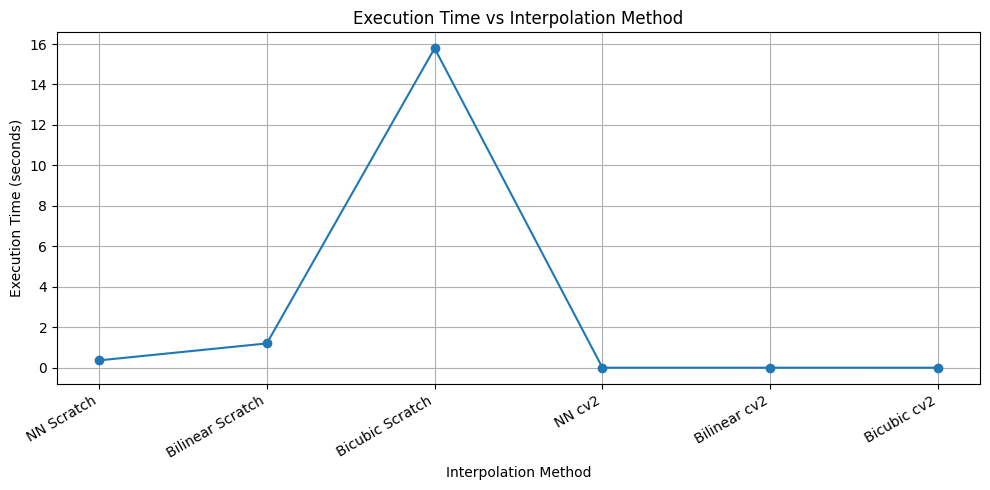

In [61]:
methods = list(timings.keys())
time_values = list(timings.values())

plt.figure(figsize=(10, 5))
plt.plot(methods, time_values, marker='o')

plt.xlabel("Interpolation Method")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time vs Interpolation Method")
plt.xticks(rotation=30, ha='right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [62]:
original = lena

images = {
    "Original": original,
    "NN Scratch": nn_s,
    "Bilinear Scratch": bl_s,
    "Bicubic Scratch": bc_s,
    "NN cv2": nn_cv2,
    "Bilinear cv2": bilinear_cv2,
    "Bicubic cv2": bicubic_cv2
}


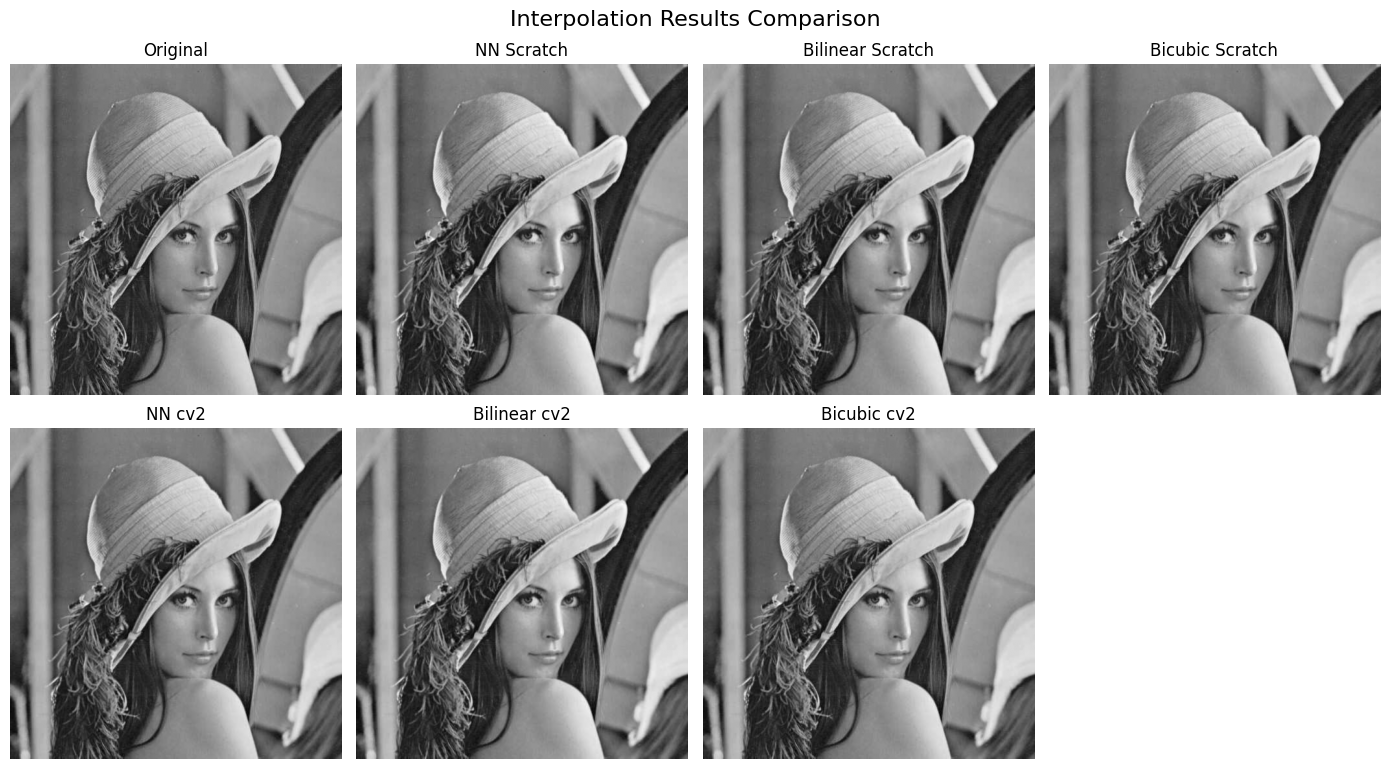

In [63]:
plt.figure(figsize=(14, 8))

for idx, (title, image) in enumerate(images.items()):
    plt.subplot(2, 4, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis("off")

plt.suptitle("Interpolation Results Comparison", fontsize=16)
plt.tight_layout()
plt.show()


In [64]:
methods = [
    "NN Scratch",
    "Bilinear Scratch",
    "Bicubic Scratch (Fixed)",
    "NN cv2",
    "Bilinear cv2",
    "Bicubic cv2"
]

psnr_values = [
    psnr(lena, nn_s),
    psnr(lena, bl_s),
    psnr(lena, bc_s),
    psnr(lena, nn_cv2),
    psnr(lena, bilinear_cv2),
    psnr(lena, bicubic_cv2)
]


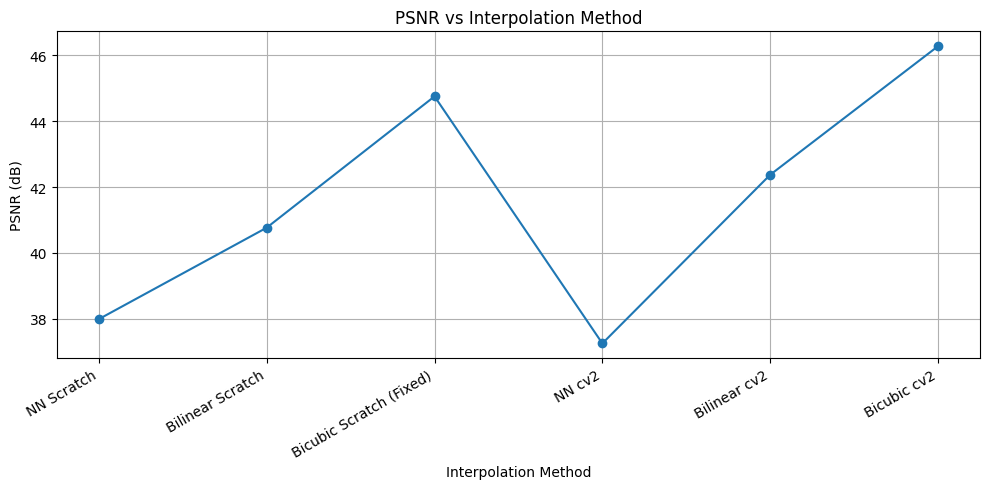

In [65]:
plt.figure(figsize=(10, 5))

plt.plot(methods, psnr_values, marker='o', linestyle='-')

plt.xlabel("Interpolation Method")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs Interpolation Method")
plt.xticks(rotation=30, ha='right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [66]:
def diff_map(original, reconstructed):
    original = original.astype(np.float64)
    reconstructed = reconstructed.astype(np.float64)
    return np.abs(original - reconstructed)


In [67]:
diff_maps = {
    "NN Scratch": diff_map(lena, nn_s),
    "Bilinear Scratch": diff_map(lena, bl_s),
    "Bicubic Scratch": diff_map(lena, bc_s),
    "NN cv2": diff_map(lena, nn_cv2),
    "Bilinear cv2": diff_map(lena, bilinear_cv2),
    "Bicubic cv2": diff_map(lena, bicubic_cv2)
}


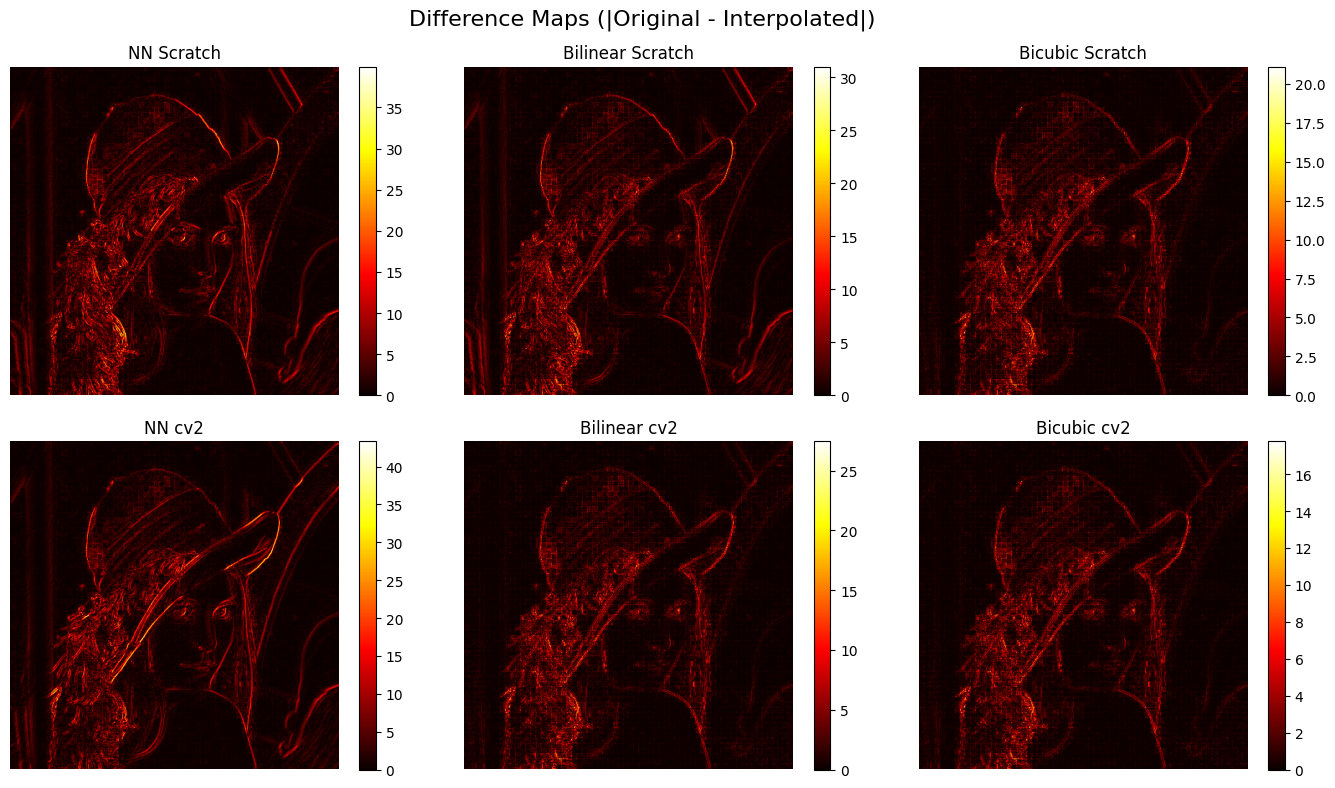

In [68]:
plt.figure(figsize=(14, 8))

for idx, (title, diff) in enumerate(diff_maps.items()):
    plt.subplot(2, 3, idx + 1)
    plt.imshow(diff, cmap="hot")
    plt.title(title)
    plt.colorbar(fraction=0.046)
    plt.axis("off")

plt.suptitle("Difference Maps (|Original - Interpolated|)", fontsize=16)
plt.tight_layout()
plt.show()
